In [297]:

'''
!!!МЕНЯЕМ ТОЛЬКО ЭТУ ЯЧЕЙКУ!!! ДАЛЬШЕ НИЧЕГО НЕ МЕНЯЕМ !!!
    Блок загрузки тестируемой модели и параметров
'''

from tensorflow.keras.models import load_model
import os


home_path_models = os.path.abspath('models')

'''Имя тестируемой модели'''
model_name='model_tanh_c1_nc1_10_l5_nl1_2000_nl2_1000_nl3_500_e10_bs64.h5'

model = load_model(f'{home_path_models}/{model_name}')

'''Даты тестирования модели не должны превышать 2023-09-09 - это последняя записаная дата'''
start_date = '2022-09-04'
end_date = '2023-09-05'

In [298]:
# Задаем дату до которой теоритически будем прогнозировать
end_future_date = '2024-12-31 23:55:00+00:00'

In [299]:
import pandas as pd


home_path_input = os.path.abspath('input_data')

# Читаем данные на которых обчали модель
df_Pl = pd.read_csv(f'{home_path_input}/imputed_filled_P_l_LR (1).csv', sep=',')


In [300]:
# Узнаем последнию известную дату. Нужна для создания промежутка значений будущих дат
end_know_date = df_Pl['time'].iloc[-1]

end_know_date_index = df_Pl[df_Pl['time'] == end_know_date].index[0] + 1


In [301]:
import numpy as np

# Создаем общий датасет с известными и будущими данными нужно для корректного общего нормирования данных

# Добавляем 5 минут чтобы последняя известная дата не попала в список для генерации будущих дат

end_know_date = pd.to_datetime(end_know_date)

# Добавление 5 минут
end_know_date = end_know_date + pd.Timedelta(minutes=5)

# Преобразование обратно в строку
end_know_date = end_know_date.strftime('%Y-%m-%d %H:%M:%S%z')

future_dates = pd.date_range(start=end_know_date, end=end_future_date, freq='5T')

future_df = pd.DataFrame({'time': future_dates, 'P_l': np.nan})

avg_pl = df_Pl['P_l'].mean()

# Заполняем Nan если они есть в датафрейме с известными данными
df_Pl['P_l'].fillna(avg_pl, inplace=True)

# Создаем общий датаферйм с известными и будущими датами для корректной нормировки данных относительно существующих и будущих дат
df_Pl_sacler = pd.concat([df_Pl, future_df], ignore_index=True)


In [302]:
# Функция нормировки дат относительно всех дат(известных и которых хотим прогнощировать)

def normalized_df(df, scaler):
# Преобразование времени в формат datetime
  df['time'] = pd.to_datetime(df['time'])
  # Создание новых столбцов
  df['year'] = df['time'].dt.year
  df['month'] = df['time'].dt.month
  df['day'] = df['time'].dt.day
  df['hour'] = df['time'].dt.hour
  df['minute'] = df['time'].dt.minute

  # Удаление исходной колонки времени
  df = df.drop('time', axis=1)

  # Нормализация данных
  df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
  return df_normalized

# Обратное масштабирование данных времени
def restored_date(df_normalized, scaler):
  df_restored = pd.DataFrame(scaler.inverse_transform(df_normalized), columns=df_normalized.columns)
  df_restored['time'] = pd.to_datetime(df_restored[['year', 'month', 'day', 'hour', 'minute']])
  df_restored = df_restored.drop(['year', 'month', 'day', 'hour', 'minute'], axis=1)
  return df_restored

In [303]:
from sklearn.preprocessing import MinMaxScaler

# Нормализация всех данных существующих и будущих
scaler = MinMaxScaler(feature_range=(0, 1))

df_Pl_normalized_all_dates = normalized_df(df_Pl_sacler, scaler)


In [304]:
# Данные для обучения отнормированные относительно всего промежутка(известных дат и дат для прогноза)

df_Pl_normalized_initial_dates = df_Pl_normalized_all_dates.loc[: end_know_date_index-1]


In [305]:
df_Pl_normalized_future_dates = df_Pl_normalized_all_dates.loc[end_know_date_index :]


In [306]:
# Данные для обучения
X_initial = df_Pl_normalized_initial_dates[['year', 'month', 'day', 'hour', 'minute']].values
y_initial = df_Pl_normalized_initial_dates['P_l'].values


In [307]:

# gреобразование в 5 мерный массив
X_initial_train = X_initial.reshape(-1, 1, 5)


In [308]:
from sklearn.model_selection import train_test_split

# Данные для обучения
X_initial = df_Pl_normalized_initial_dates[['year', 'month', 'day', 'hour', 'minute']].values
y_initial = df_Pl_normalized_initial_dates['P_l'].values

# Преобразование в 5-мерный массив
X_initial_train = X_initial.reshape(-1, 1, 5)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_initial_train, y_initial, test_size=0.01, random_state=42)


In [309]:
import pandas as pd

def get_indices_between_dates(df_Pl_sacler, start_date, end_date):
    """
    Получает DataFrame, начальную и конечную даты, возвращает список индексов,
    соответствующих датам в заданном диапазоне.
    Нужна для получения индексов времени которые мы хотим спрогнозировать
    Parameters:
    - df_Pl_sacler: pandas.DataFrame
        DataFrame с колонкой 'time', содержащей даты в формате 'yyyy-mm-dd hh:mm:ss+00:00'.
    - start_date: str
        Начальная дата в формате 'yyyy-mm-dd'.
    - end_date: str
        Конечная дата в формате 'yyyy-mm-dd'.

    Returns:
    - list
        Список индексов, соответствующих датам в заданном диапазоне.
    """
    # Преобразование колонки 'time' в формат datetime
    df_Pl_sacler['time'] = pd.to_datetime(df_Pl_sacler['time'])

    # Выборка индексов для дат в заданном диапазоне
    indices = df_Pl_sacler.loc[(df_Pl_sacler['time'] >= start_date) & (df_Pl_sacler['time'] <= end_date)].index

    return indices



In [310]:
'''
Блок получения нормированных дат для подстановки в модель
'''


df_Pl_all_dates = df_Pl_sacler.copy()

# выбираем индексы для которых хотим сделать прогноз из общего датасета(с бущими и настоящими датами)
indexes = get_indices_between_dates(df_Pl_all_dates, start_date, end_date)

# Нормализуем датасет чтобы получить нормализованные даты чтобы корректно поместить их в модель для предсказания
df_Pl_all_dates_normilize = normalized_df(df_Pl_all_dates, scaler)

# Получаем датафрейм с нормированными датами на промежуток прогноза
df_Pl_sacler_for_predict = df_Pl_all_dates_normilize.loc[indexes]

X_predict = df_Pl_sacler_for_predict[['year', 'month', 'day', 'hour', 'minute']].values

X_predict = X_predict.reshape(-1, 1, 5)

In [311]:
# Предсказания
X_predict_scaled = X_predict
X_predict_cnn = X_predict
X_predict_lstm = X_predict

predictions = model.predict([X_predict_cnn, X_predict_lstm])

# Обратное масштабирование предсказанных значений

3295/3295 [==============================] - 77s 23ms/step


In [312]:
df_predict = df_Pl_sacler_for_predict.copy()
df_predict['P_l'] = predictions.flatten()

df_predict = restored_date(df_predict, scaler)

In [313]:
df = pd.read_csv(f'{home_path_input}/imputed_filled_P_l_LR (1).csv', sep=',')

df_comporative = df.loc[indexes]

In [314]:
df_comporative['time'] = df_comporative['time'].astype(df_predict['time'].dtype)


In [315]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


def calculate_metrics(df_orig, df_test):
    avg_pl = df_Pl['P_l'].mean()

# Заполняем Nan если они есть в датафрейме с известными данными
    df_orig['P_l'].fillna(avg_pl, inplace=True)



    y_true = df_orig
    y_pred = df_test

    y_true_mean = y_true['P_l'].mean()
        # Расчет RMSE
    rmse = np.sqrt(mean_squared_error(y_true['P_l'].values , y_pred['P_l'].values ))

    # Расчет R^2
    ss_res = np.sum((y_true['P_l'].values  - y_pred['P_l'].values ) ** 2)
    ss_tot = np.sum((y_true['P_l'].values  - y_true_mean) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    # Расчет MAE
    mae = mean_absolute_error(y_true['P_l'].values , y_pred['P_l'].values )

    # Расчет MAPE
    mape = np.mean(np.abs((y_true['P_l'].values - y_pred['P_l'].values) / y_true['P_l'].values)) * 100
    # Расчет WMAPE
    wmape = np.sum(np.abs(y_true['P_l'].values  - y_pred['P_l'].values )) / np.sum(np.abs(y_true['P_l'].values )) * 100

    return rmse, r2, mae, mape, wmape

In [316]:
rmse, r2, mae, mape, wmape = calculate_metrics(df_comporative, df_predict)


In [317]:
'''Называем график по имени модели'''

name_gragh = model_name[:-3]

'''Путь к директории для сохранения графика'''
home_path_save_graph = os.path.abspath('comparative_results')


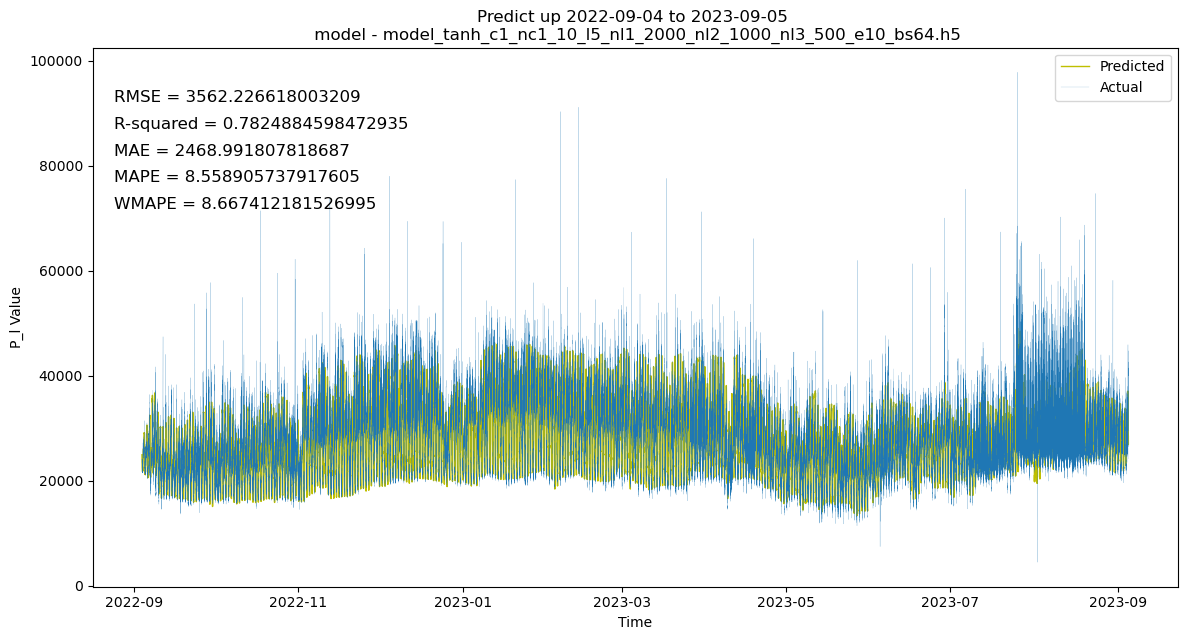

In [320]:
from matplotlib import pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df_predict['time'], df_predict['P_l'], linewidth=1, color='y', label='Predicted')
plt.plot(df_comporative['time'], df_comporative['P_l'], linewidth=0.1, label='Actual')
plt.title(label=f"Predict up {start_date} to {end_date} \n model - {model_name}")
plt.ylabel("P_l Value")
plt.xlabel("Time")
plt.legend()  # Добавляем легенду

# Добавляем информацию о метриках
plt.text(0.02, 0.9, f'RMSE = {rmse}', transform=plt.gca().transAxes, fontsize=12)
plt.text(0.02, 0.85, f'R-squared = {r2}', transform=plt.gca().transAxes, fontsize=12)
plt.text(0.02, 0.8, f'MAE = {mae}', transform=plt.gca().transAxes, fontsize=12)
plt.text(0.02, 0.75, f'MAPE = {mape}', transform=plt.gca().transAxes, fontsize=12)
plt.text(0.02, 0.7, f'WMAPE = {wmape}', transform=plt.gca().transAxes, fontsize=12)

plt.savefig(f'{home_path_save_graph}/{name_gragh}.png')

plt.show()


In [319]:
print(f'RMSE = {rmse}')
print(f'R-squared = {r2}')
print(f'MAE = {mae}')
print(f'MAPE = {mape}')
print(f'WMAPE = {wmape}')

RMSE = 3562.226618003209
R-squared = 0.7824884598472935
MAE = 2468.991807818687
MAPE = 8.558905737917605
WMAPE = 8.667412181526995
